In [2]:
# Import necessary libraries
import os
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Suppress TensorFlow INFO and WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Enable memory growth if using GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data Loading and Preprocessing

In [3]:
# Load the data
df = pd.read_csv('../data/raw/Train.csv')

# Convert Time to datetime with explicit format (day first)
df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')

# Select features (excluding Location and index column)
feature_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m',
                   'WD_10m', 'WD_100m', 'WG_10m', 'Power']

# Create feature matrix
data = df[feature_columns].values

# Determine split indices based on the original data length
total_samples = data.shape[0]
train_end = int(0.7 * total_samples)
val_end = train_end + int(0.15 * total_samples)

# Split the data
train_data = data[:train_end]
val_data = data[train_end:val_end]
test_data = data[val_end:]

# Initialize scaler
scaler = StandardScaler()

# Fit the scaler on the training data (excluding the target column)
scaled_train_features = scaler.fit_transform(train_data[:, :-1])

# Transform validation and test data
scaled_val_features = scaler.transform(val_data[:, :-1])
scaled_test_features = scaler.transform(test_data[:, :-1])

# Combine scaled features with the target variable
scaled_train_data = np.column_stack((scaled_train_features, train_data[:, -1]))
scaled_val_data = np.column_stack((scaled_val_features, val_data[:, -1]))
scaled_test_data = np.column_stack((scaled_test_features, test_data[:, -1]))

print("Data shapes after scaling and splitting:")
print(f"Training data shape: {scaled_train_data.shape}")
print(f"Validation data shape: {scaled_val_data.shape}")
print(f"Test data shape: {scaled_test_data.shape}")

Data shapes after scaling and splitting:
Training data shape: (98112, 9)
Validation data shape: (21024, 9)
Test data shape: (21024, 9)


## Creating Sliding Windows for Time Series Data

In [4]:
def create_windows(data, window_size=12, target_col=-1):
    """
    Create sliding windows from time series data.
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        target = data[i + window_size, target_col]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

# Create windows for training, validation, and test data
X_train, y_train = create_windows(scaled_train_data, window_size=12)
X_val, y_val = create_windows(scaled_val_data, window_size=12)
X_test, y_test = create_windows(scaled_test_data, window_size=12)

print("\nWindowed dataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")


Windowed dataset shapes:
X_train: (98100, 12, 9)
y_train: (98100,)
X_val:   (21012, 12, 9)
y_val:   (21012,)
X_test:  (21012, 12, 9)
y_test:  (21012,)


## Model Definition

In [6]:
# Create model
def create_model():
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # sigmoid because Power is normalized 0-1
    ])
    # Compile model with SGD optimizer (we'll recompile before SGD training)
    model.compile(
        optimizer=SGD(learning_rate=0.01, momentum=0.9),
        loss='mse',
        metrics=['mae', 'mse']
    )
    return model

# Initialize the model
model = create_model()

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 108)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

## Genetic Algorithm Pretraining

In [8]:
# Define parameters for the genetic algorithm
population_size = 50
generations = 100
mutation_rate = 0.01
elite_frac = 0.1
patience = 10

# Fitness function
def evaluate_population(models):
    scores = []
    for model in models:
        predictions = model.predict(X_val, verbose=0).squeeze()
        mse = mean_squared_error(y_val, predictions)
        scores.append(-mse)  # Negative MSE since we want to minimize it
    return np.array(scores)

# Initialize population
def initialize_population(population_size):
    return [create_model() for _ in range(population_size)]

# Selection
def select_mating_pool(population, scores, elite_frac):
    elite_size = max(1, int(elite_frac * len(scores)))
    elite_indices = np.argsort(scores)[-elite_size:]
    return [population[i] for i in elite_indices], scores[elite_indices]

# Crossover
def crossover(parent1, parent2):
    child = create_model()
    for i, layer in enumerate(child.layers):
        if hasattr(layer, 'weights'):
            weights1 = parent1.layers[i].get_weights()
            weights2 = parent2.layers[i].get_weights()
            child_weights = [0.5 * (w1 + w2) for w1, w2 in zip(weights1, weights2)]
            layer.set_weights(child_weights)
    return child

# Mutation
def mutate(model, mutation_rate):
    for layer in model.layers:
        if hasattr(layer, 'weights'):
            weights = layer.get_weights()
            new_weights = [w + mutation_rate * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(new_weights)

# Genetic algorithm main loop with early stopping
def genetic_algorithm(patience=10):
    # Initialize history lists
    best_mse_list = []
    mean_mse_list = []
    std_mse_list = []

    # Initialize variables
    population = initialize_population(population_size)
    best_score = None
    best_generation = 0
    no_improvement_count = 0
    for generation in range(generations):
        scores = evaluate_population(population)
        best_mse = -np.max(scores)
        mean_mse = -np.mean(scores)
        std_mse = np.std(scores)

        # Append to history lists
        best_mse_list.append(best_mse)
        mean_mse_list.append(mean_mse)
        std_mse_list.append(std_mse)

        # Single output line per generation with relevant information
        print(f"Generation {generation + 1} - Best MSE: {best_mse:.6f}, Mean MSE: {mean_mse:.6f}, Std MSE: {std_mse:.6f}")

        # Early stopping logic
        if best_score is None or best_mse < best_score:
            best_score = best_mse
            best_generation = generation
            no_improvement_count = 0
            # Save the best population
            best_population = population.copy()
            best_elite_scores = scores.copy()
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"No improvement in best MSE for {patience} generations. Early stopping.")
                break

        # Select mating pool
        elite, elite_scores = select_mating_pool(population, scores, elite_frac)
        new_population = elite.copy()

        # Create offspring
        while len(new_population) < population_size:
            parent1, parent2 = np.random.choice(elite, 2)
            child = crossover(parent1, parent2)
            mutate(child, mutation_rate)
            new_population.append(child)

        # Update population
        population = new_population
    else:
        # If loop wasn't broken by early stopping, save the last population
        best_population = population.copy()
        best_elite_scores = scores.copy()
        best_generation = generations - 1

    print(f"Best MSE achieved at generation {best_generation + 1}: {best_score:.6f}")

    # Prepare history dictionary
    ga_history = {
        'best_mse': best_mse_list,
        'mean_mse': mean_mse_list,
        'std_mse': std_mse_list
    }

    return best_population, best_elite_scores, ga_history, best_generation, best_score

# Run the genetic algorithm with early stopping
final_population, final_scores, ga_history, best_generation, best_score = genetic_algorithm(patience=patience)

# Identify the best model from the final population
best_model_index = np.argmax(final_scores)
best_ga_model = final_population[best_model_index]

# Load the GA-trained weights into our main model
model.set_weights(best_ga_model.get_weights())

Generation 1 - Best MSE: 0.037865, Mean MSE: 0.153089, Std MSE: 0.080713
Generation 2 - Best MSE: 0.036776, Mean MSE: 0.068400, Std MSE: 0.009770
Generation 3 - Best MSE: 0.035780, Mean MSE: 0.058583, Std MSE: 0.011458
Generation 4 - Best MSE: 0.035483, Mean MSE: 0.036739, Std MSE: 0.000777
Generation 5 - Best MSE: 0.034704, Mean MSE: 0.035785, Std MSE: 0.000500
Generation 6 - Best MSE: 0.034334, Mean MSE: 0.035185, Std MSE: 0.000546
Generation 7 - Best MSE: 0.033837, Mean MSE: 0.034733, Std MSE: 0.000441
Generation 8 - Best MSE: 0.033521, Mean MSE: 0.034366, Std MSE: 0.000493
Generation 9 - Best MSE: 0.033122, Mean MSE: 0.033776, Std MSE: 0.000375
Generation 10 - Best MSE: 0.032658, Mean MSE: 0.033375, Std MSE: 0.000347
Generation 11 - Best MSE: 0.032320, Mean MSE: 0.033089, Std MSE: 0.000353
Generation 12 - Best MSE: 0.031766, Mean MSE: 0.032585, Std MSE: 0.000443
Generation 13 - Best MSE: 0.031279, Mean MSE: 0.032036, Std MSE: 0.000400
Generation 14 - Best MSE: 0.030957, Mean MSE: 0

## Fine-Tuning with SGD

In [9]:
# Recompile the model for SGD training
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='mse',
    metrics=['mae', 'mse']
)

# Early stopping callback for SGD training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model using SGD
history_sgd = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0251 - mae: 0.1205 - mse: 0.0251 - val_loss: 0.0092 - val_mae: 0.0749 - val_mse: 0.0092
Epoch 2/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0117 - mae: 0.0834 - mse: 0.0117 - val_loss: 0.0063 - val_mae: 0.0615 - val_mse: 0.0063
Epoch 3/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 2s 508us/step - loss: 0.0088 - mae: 0.0718 - mse: 0.0088 - val_loss: 0.0050 - val_mae: 0.0548 - val_mse: 0.0050
Epoch 4/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0072 - mae: 0.0649 - mse: 0.0072 - val_loss: 0.0042 - val_mae: 0.0502 - val_mse: 0.0042
Epoch 5/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0062 - mae: 0.0600 - mse: 0.0062 - val_loss: 0.0038 - val_mae: 0.0479 - val_mse: 0.0038
Epoch 6/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0055 - mae: 0.0569 - mse: 0.0055 - val_loss: 0.0033 - val_mae: 0.0445 - val_mse: 0.0033
Epoch 7/100
3066/3066 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0051 - mae: 0.0

## Evaluating the Hybrid Model

In [10]:
# Create a unique directory for the results based on the current timestamp
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'../results/hybrid_run_{timestamp}'
os.makedirs(results_dir, exist_ok=True)

# Evaluate on validation set
val_predictions = model.predict(X_val)
r2_val = r2_score(y_val, val_predictions)
mse_val = mean_squared_error(y_val, val_predictions)
mae_val = mean_absolute_error(y_val, val_predictions)
print(f"\nValidation R² score: {r2_val:.4f}")
print(f"Validation MSE: {mse_val:.6f}")
print(f"Validation MAE: {mae_val:.6f}")

# Evaluate on test set
test_predictions = model.predict(X_test)
r2_test = r2_score(y_test, test_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
mae_test = mean_absolute_error(y_test, test_predictions)
print(f"\nTest R² score: {r2_test:.4f}")
print(f"Test MSE: {mse_test:.6f}")
print(f"Test MAE: {mae_test:.6f}")

# Save evaluation metrics
evaluation_metrics = {
    'validation_r2_score': float(r2_val),
    'validation_mse': float(mse_val),
    'validation_mae': float(mae_val),
    'test_r2_score': float(r2_test),
    'test_mse': float(mse_test),
    'test_mae': float(mae_test),
    'best_generation_ga': int(best_generation + 1),
    'best_mse_ga': float(best_score),
    'epochs_sgd': len(history_sgd.history['loss']),
    'best_val_loss_sgd': float(min(history_sgd.history['val_loss'])),
}

evaluation_metrics_path = os.path.join(results_dir, 'evaluation_metrics.json')
with open(evaluation_metrics_path, 'w') as f:
    json.dump(evaluation_metrics, f, indent=4)

657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step

Validation R² score: 0.9881
Validation MSE: 0.000593
Validation MAE: 0.018096
657/657 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step

Test R² score: 0.9911
Test MSE: 0.000479
Test MAE: 0.016443


## Visualizations

### GA Training History

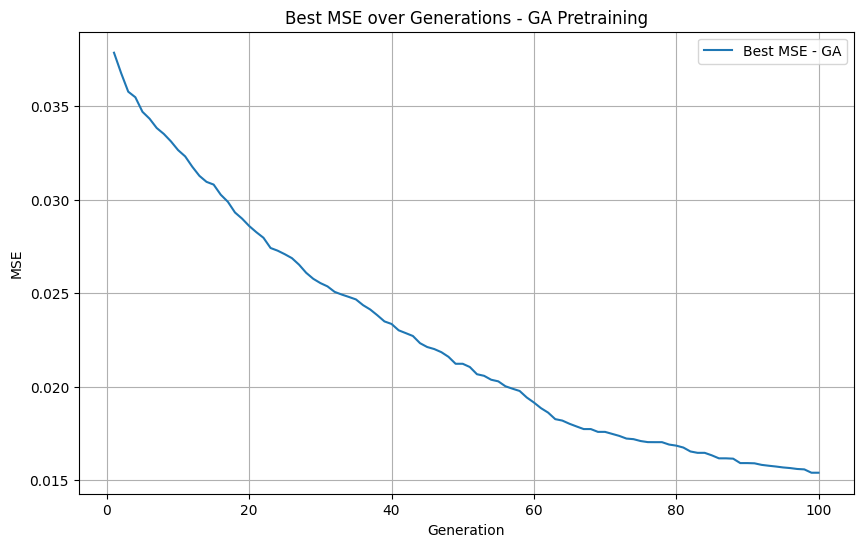

In [11]:
# Plot GA Training History
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ga_history['best_mse']) + 1), ga_history['best_mse'], label='Best MSE - GA')
plt.xlabel('Generation')
plt.ylabel('MSE')
plt.title('Best MSE over Generations - GA Pretraining')
plt.grid(True)
plt.legend()
best_mse_plot_path = os.path.join(results_dir, 'best_mse_over_generations_ga.png')
plt.savefig(best_mse_plot_path)
plt.show()

### SGD Training History

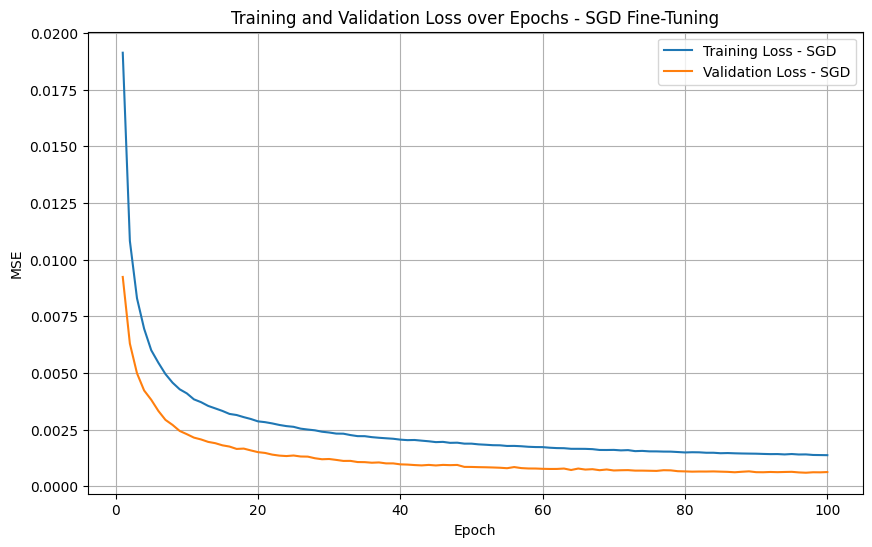

In [12]:
# Plot SGD Training History
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history_sgd.history['loss']) + 1), history_sgd.history['loss'], label='Training Loss - SGD')
plt.plot(range(1, len(history_sgd.history['val_loss']) + 1), history_sgd.history['val_loss'], label='Validation Loss - SGD')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss over Epochs - SGD Fine-Tuning')
plt.grid(True)
plt.legend()
sgd_training_plot_path = os.path.join(results_dir, 'training_history_sgd.png')
plt.savefig(sgd_training_plot_path)
plt.show()

### Combined Training History

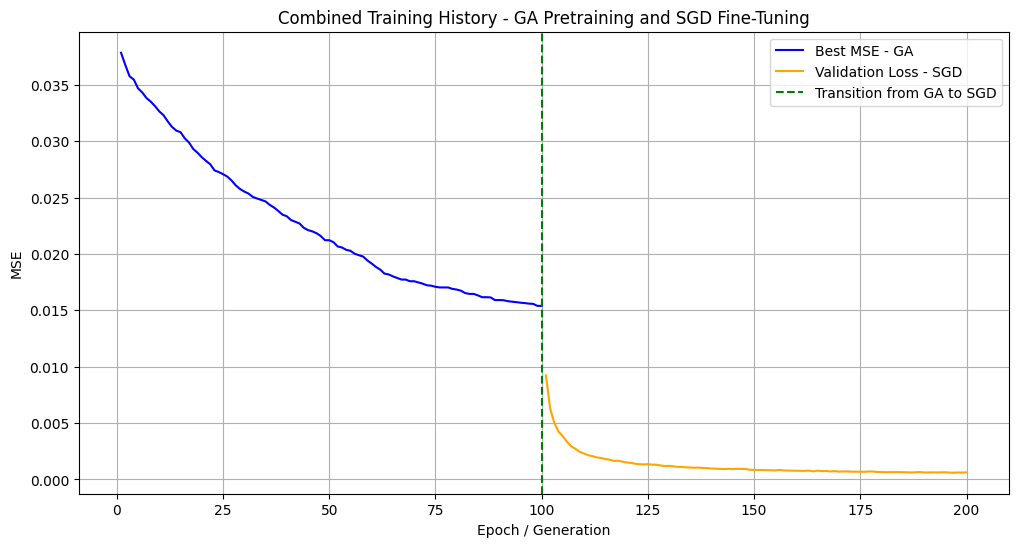

In [13]:
# Combine GA and SGD training history
total_epochs = len(ga_history['best_mse']) + len(history_sgd.history['loss'])
combined_mse = ga_history['best_mse'] + history_sgd.history['val_loss']

# Create epoch indices
ga_epochs = range(1, len(ga_history['best_mse']) + 1)
sgd_epochs = range(len(ga_history['best_mse']) + 1, total_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(ga_epochs, ga_history['best_mse'], label='Best MSE - GA', color='blue')
plt.plot(sgd_epochs, history_sgd.history['val_loss'], label='Validation Loss - SGD', color='orange')
plt.xlabel('Epoch / Generation')
plt.ylabel('MSE')
plt.title('Combined Training History - GA Pretraining and SGD Fine-Tuning')
plt.axvline(x=len(ga_history['best_mse']), color='green', linestyle='--', label='Transition from GA to SGD')
plt.grid(True)
plt.legend()
combined_training_plot_path = os.path.join(results_dir, 'combined_training_history.png')
plt.savefig(combined_training_plot_path)
plt.show()

## Visualizations Using the Test Set

### Scatter Plot: Predicted vs. Actual Values

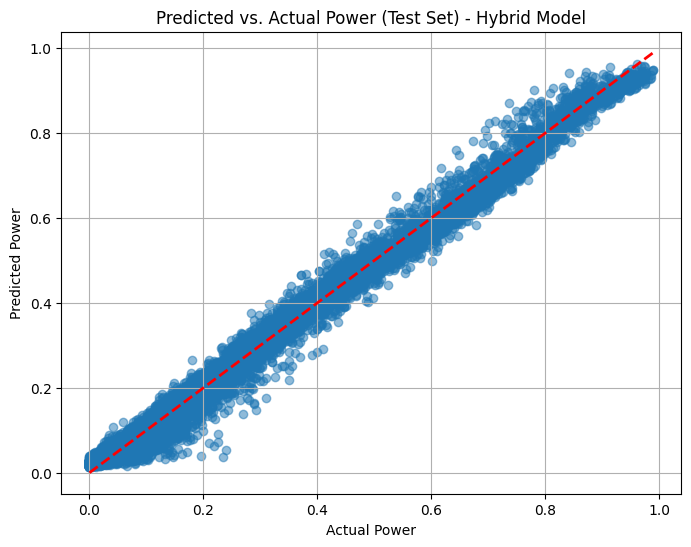

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('Predicted vs. Actual Power (Test Set) - Hybrid Model')
plt.grid(True)
scatter_plot_path = os.path.join(results_dir, 'predicted_vs_actual_scatter_hybrid.png')
plt.savefig(scatter_plot_path)
plt.show()

### Line Chart: Actual vs. Predicted Values Over Time

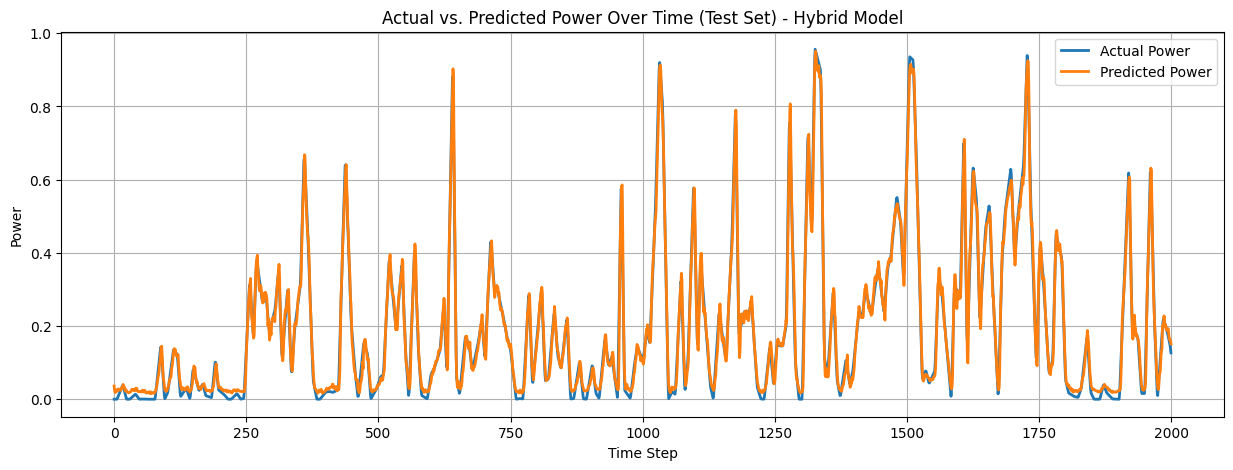

In [15]:
# Select a small continuous portion of the data
start_idx = 0  # Adjust as needed
end_idx = start_idx + 2000

plt.figure(figsize=(15, 5))
plt.plot(range(start_idx, end_idx), y_test[start_idx:end_idx], label='Actual Power', linewidth=2)
plt.plot(range(start_idx, end_idx), test_predictions[start_idx:end_idx], label='Predicted Power', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.title('Actual vs. Predicted Power Over Time (Test Set) - Hybrid Model')
plt.legend()
plt.grid(True)
line_chart_path = os.path.join(results_dir, 'actual_vs_predicted_over_time_hybrid.png')
plt.savefig(line_chart_path)
plt.show()

### Distribution of Residuals

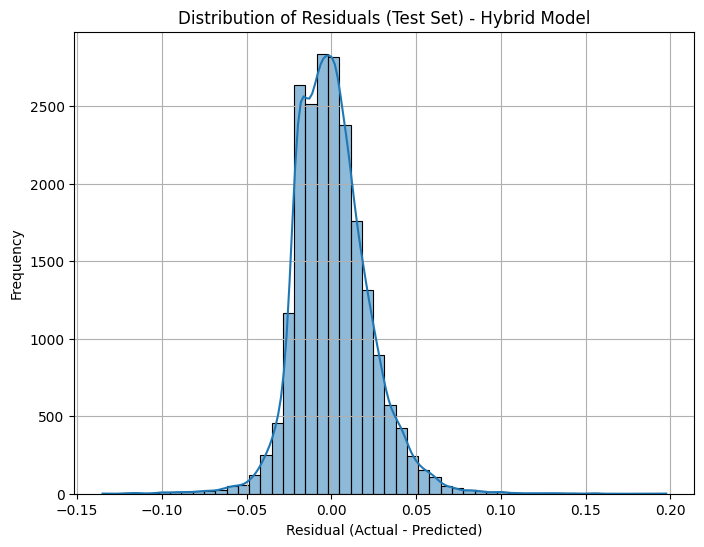

In [16]:
residuals = y_test - test_predictions.squeeze()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Test Set) - Hybrid Model')
plt.grid(True)
residuals_plot_path = os.path.join(results_dir, 'residuals_distribution_hybrid.png')
plt.savefig(residuals_plot_path)
plt.show()

### Saving the Model and Artifacts

In [17]:
# 1. Save Model Weights and Architecture

## Save the model weights
model_weights_path = os.path.join(results_dir, 'hybrid_model.weights.h5')
model.save_weights(model_weights_path)

## Save the model architecture to JSON
model_json = model.to_json()
model_architecture_path = os.path.join(results_dir, 'hybrid_model_architecture.json')
with open(model_architecture_path, 'w') as json_file:
    json_file.write(model_json)

# 2. Save Training Parameters

## Save training parameters
training_params = {
    'optimizer_sgd': 'SGD',
    'learning_rate': 0.01,
    'momentum': 0.9,
    'loss_function': 'mse',
    'batch_size': 32,
    'epochs_sgd': len(history_sgd.history['loss']),
    'window_size': 12,
    'n_timesteps': X_train.shape[1],
    'n_features': X_train.shape[2],
    'early_stopping_patience': 10,
    'train_size': X_train.shape[0],
    'validation_size': X_val.shape[0],
    'test_size': X_test.shape[0],
    'random_seed': 42,
    'population_size_ga': population_size,
    'generations_ga': len(ga_history['best_mse']),
    'mutation_rate_ga': mutation_rate,
    'elite_frac_ga': elite_frac,
    'patience_ga': patience,
}

training_params_path = os.path.join(results_dir, 'training_params.json')
with open(training_params_path, 'w') as f:
    json.dump(training_params, f, indent=4)

# 3. Save Training History

## Save GA training history
ga_training_history_path = os.path.join(results_dir, 'ga_training_history.json')
with open(ga_training_history_path, 'w') as f:
    json.dump(ga_history, f, indent=4)

## Save SGD training history
sgd_training_history_path = os.path.join(results_dir, 'sgd_training_history.json')
with open(sgd_training_history_path, 'w') as f:
    json.dump(history_sgd.history, f, indent=4)

# 4. Save Scaler Object

## Save the scaler used for data preprocessing
scaler_path = os.path.join(results_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# 5. Save Model Summary

## Capture the model summary to a text file
model_summary_path = os.path.join(results_dir, 'hybrid_model_summary.txt')
with open(model_summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# 6. Notify Completion and Results Directory
print(f"\nAll results have been saved to the directory: {results_dir}")


All results have been saved to the directory: ../results/hybrid_run_20241112_113541
